In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns  # for nicer plots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

!pip install keras-tuner
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from keras_tuner import Objective

sns.set(style="darkgrid")  # default style

In [ ]:
# Load in dataset
from google.colab import drive
drive.mount('/content/drive')

weather_df = pd.read_csv('/content/drive/MyDrive/datasci_207_final_project/data/cleaned_weather.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning

In [ ]:
# Rename the columns from code to description.
col_rename = {'p': 'atmospheric_pressure',
              'T': 'air_temperature',
              'Tpot': 'potential_temperature',
              'Tdew': 'dew_point_temperature',
              'rh': 'relative_humidity',
              'VPmax': 'maximum_vapor_pressure',
              'VPact': 'actual_vapor_pressure',
              'VPdef': 'vapor_pressure_deficit',
              'sh': 'specific_humidity',
              'H2OC': 'water_vapor_concentration',
              'rho': 'air_density',
              'wv': 'wind_speed',
              'max. wv': 'max_wind_speed',
              'wd': 'wind_direction',
              'rain': 'total_rainfall',
              'raining': 'duration_of_rain',
              'SWDR': 'solar_radiation',
              'PAR': 'photosynthetically_active_radiation',
              'max. PAR': 'max_photosynthetically_active_radiation',
              'Tlog': 'temperature',
              'OT': 'operational_timestamp'}

weather_df.rename(columns=col_rename, inplace=True)

# Review the result
weather_df.columns

Index(['date', 'atmospheric_pressure', 'air_temperature',
       'potential_temperature', 'dew_point_temperature', 'relative_humidity',
       'maximum_vapor_pressure', 'actual_vapor_pressure',
       'vapor_pressure_deficit', 'specific_humidity',
       'water_vapor_concentration', 'air_density', 'wind_speed',
       'max_wind_speed', 'wind_direction', 'total_rainfall',
       'duration_of_rain', 'solar_radiation',
       'photosynthetically_active_radiation',
       'max_photosynthetically_active_radiation', 'temperature'],
      dtype='object')

In [ ]:
# Check the dtypes of each column.
weather_df.dtypes

,0
date,object
atmospheric_pressure,float64
air_temperature,float64
potential_temperature,float64
dew_point_temperature,float64
relative_humidity,float64
maximum_vapor_pressure,float64
actual_vapor_pressure,float64
vapor_pressure_deficit,float64
specific_humidity,float64


In [ ]:
# Convert date to timestamp from object.
weather_df['date'] = weather_df['date'].astype('datetime64[ns]')
weather_df['date']

,date
0,2020-01-01 00:10:00
1,2020-01-01 00:20:00
2,2020-01-01 00:30:00
3,2020-01-01 00:40:00
4,2020-01-01 00:50:00
...,...
52691,2020-12-31 23:20:00
52692,2020-12-31 23:30:00
52693,2020-12-31 23:40:00
52694,2020-12-31 23:50:00


In [ ]:
# Check for nulls.
weather_df.isna().sum()

,0
date,0
atmospheric_pressure,0
air_temperature,0
potential_temperature,0
dew_point_temperature,0
relative_humidity,0
maximum_vapor_pressure,0
actual_vapor_pressure,0
vapor_pressure_deficit,0
specific_humidity,0


In [ ]:
# Look at the various columns to ID what needs to be cleaned.
weather_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,52696,2020-07-02 00:11:52.198269440,2020-01-01 00:10:00,2020-04-01 11:47:30,2020-07-02 00:45:00,2020-10-01 12:22:30,2021-01-01 00:00:00,NaN
atmospheric_pressure,52696.0,989.989233,955.58,984.8,990.92,995.93,1020.07,9.207149
air_temperature,52696.0,10.818241,-6.44,4.59,10.23,16.18,34.8,7.468671
potential_temperature,52696.0,284.796938,266.19,278.55,284.32,290.26,309.13,7.616995
dew_point_temperature,52696.0,5.409105,-13.81,0.7775,5.26,9.7,20.5,5.956722
relative_humidity,52696.0,72.487133,21.16,58.82,75.4,87.9,100.0,19.23026
maximum_vapor_pressure,52696.0,14.487046,3.77,8.48,12.48,18.42,55.67,7.63296
actual_vapor_pressure,52696.0,9.676828,2.09,6.46,8.89,12.05,24.16,4.023504
vapor_pressure_deficit,52696.0,4.810131,0.0,1.17,2.74,6.44,42.1,5.53932
specific_humidity,52696.0,6.111159,1.3,4.07,5.61,7.62,15.4,2.561536


In [ ]:
# Investigate bad values and set to 0.

# Set -9999 wind speed to 0.
ws = weather_df['wind_speed']
bad_ws = ws == -9999
ws[bad_ws] = 0

# Set -9999 radiation to 0.
mpar = weather_df['max_photosynthetically_active_radiation']
bad_mpar = mpar == -9999
mpar[bad_mpar] = 0

# Check the data.
weather_df.describe().transpose()

<ipython-input-8-440534b4f0f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws[bad_ws] = 0
<ipython-input-8-440534b4f0f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpar[bad_mpar] = 0


,count,mean,min,25%,50%,75%,max,std
date,52696,2020-07-02 00:11:52.198269440,2020-01-01 00:10:00,2020-04-01 11:47:30,2020-07-02 00:45:00,2020-10-01 12:22:30,2021-01-01 00:00:00,NaN
atmospheric_pressure,52696.0,989.989233,955.58,984.8,990.92,995.93,1020.07,9.207149
air_temperature,52696.0,10.818241,-6.44,4.59,10.23,16.18,34.8,7.468671
potential_temperature,52696.0,284.796938,266.19,278.55,284.32,290.26,309.13,7.616995
dew_point_temperature,52696.0,5.409105,-13.81,0.7775,5.26,9.7,20.5,5.956722
relative_humidity,52696.0,72.487133,21.16,58.82,75.4,87.9,100.0,19.23026
maximum_vapor_pressure,52696.0,14.487046,3.77,8.48,12.48,18.42,55.67,7.63296
actual_vapor_pressure,52696.0,9.676828,2.09,6.46,8.89,12.05,24.16,4.023504
vapor_pressure_deficit,52696.0,4.810131,0.0,1.17,2.74,6.44,42.1,5.53932
specific_humidity,52696.0,6.111159,1.3,4.07,5.61,7.62,15.4,2.561536


# Get Averaged Hourly Data

In [ ]:
# Create separate month, day, hour columns (since all data is 2020 we don't need year)
weather_df['month'] = weather_df['date'].apply(lambda x: x.month)
weather_df['day'] = weather_df['date'].apply(lambda x: x.day)
weather_df['hour'] = weather_df['date'].apply(lambda x: x.hour)

In [ ]:
# Group by month, day, hour to get hourly data (take average)
final_weather_df = weather_df.groupby(by=['month', 'day', 'hour']).mean().reset_index()
final_weather_df.head()

,month,day,hour,date,atmospheric_pressure,air_temperature,potential_temperature,dew_point_temperature,relative_humidity,maximum_vapor_pressure,...,air_density,wind_speed,max_wind_speed,wind_direction,total_rainfall,duration_of_rain,solar_radiation,photosynthetically_active_radiation,max_photosynthetically_active_radiation,temperature
0,1,1,0,2020-03-02 00:25:00,1003.633333,0.816667,273.696667,-1.341667,85.416667,6.485000,...,1273.500000,0.705000,1.313333,210.916667,0.0,0.0,0.0,0.0,0.0,11.925000
1,1,1,1,2020-01-01 01:25:00,1008.356667,0.141667,272.650000,-1.661667,87.600000,6.170000,...,1282.693333,0.781667,1.353333,177.800000,0.0,0.0,0.0,0.0,0.0,12.063333
2,1,1,2,2020-01-01 02:25:00,1008.333333,-0.153333,272.360000,-1.800000,88.583333,6.038333,...,1284.068333,0.510000,1.230000,169.363333,0.0,0.0,0.0,0.0,0.0,12.008333
3,1,1,3,2020-01-01 03:25:00,1008.166667,-0.615000,271.913333,-2.075000,89.783333,5.841667,...,1286.078333,0.908333,1.506667,185.701667,0.0,0.0,0.0,0.0,0.0,11.558333
4,1,1,4,2020-01-01 04:25:00,1007.898333,-1.416667,271.131667,-2.613333,91.500000,5.503333,...,1289.638333,1.008333,1.896667,166.433333,0.0,0.0,0.0,0.0,0.0,10.868333


# Create Lagged Moving Averaged Features
We want to predict future average hourly wind speed - thus need to use moving averaged of previous hours of weather features to predict a current average hour of wind speed

In [ ]:
# How far back do we want to look at the data?
window_size = 6

# Create lagged feature list
lagged_features = list(final_weather_df.columns)
lagged_features = [word for word in lagged_features if word not in ['date', 'month', 'day', 'hour', 'wind_speed']]

for col in lagged_features:
  final_weather_df[col] = final_weather_df[col].rolling(window = window_size).mean().shift(1) #shift back one hour so we don't use current hour's weather features to predict the current wind speed

# Add lagged moving average wind speed
final_weather_df['lagged_ma_wind_speed'] = final_weather_df['wind_speed'].rolling(window = window_size).mean().shift(1)

# Remove first few rows since all features will be NA since there is no previous hours to look at
final_weather_df = final_weather_df.iloc[window_size:, :]

final_weather_df.head()

,month,day,hour,date,atmospheric_pressure,air_temperature,potential_temperature,dew_point_temperature,relative_humidity,maximum_vapor_pressure,...,wind_speed,max_wind_speed,wind_direction,total_rainfall,duration_of_rain,solar_radiation,photosynthetically_active_radiation,max_photosynthetically_active_radiation,temperature,lagged_ma_wind_speed
6,1,1,6,2020-01-01 06:25:00,1007.365000,-0.571667,272.018056,-2.101111,89.383333,5.872222,...,0.783333,1.498889,181.449722,0.0,0.0,0.000000,0.000000,0.000000,11.413611,0.813056
7,1,1,7,2020-01-01 07:25:00,1008.103889,-1.152222,271.380556,-2.445833,90.911111,5.627778,...,0.878333,1.534444,176.444167,0.0,0.0,0.000000,0.000000,0.000000,11.000278,0.826111
8,1,1,8,2020-01-01 08:25:00,1008.073611,-1.600833,270.935833,-2.724722,92.025000,5.442778,...,0.795000,1.584444,177.019167,0.0,0.0,0.000000,0.000000,0.000000,10.497500,0.842222
9,1,1,9,2020-01-01 09:25:00,1008.032500,-2.064444,270.476111,-3.045278,92.972222,5.255833,...,0.833333,1.606111,177.994722,0.0,0.0,1.620833,3.480278,4.380833,9.975556,0.889722
10,1,1,10,2020-01-01 10:25:00,1008.044722,-2.450278,270.090278,-3.345000,93.536111,5.101944,...,0.586667,1.606667,169.134444,0.0,0.0,20.450833,29.890556,33.408056,9.539444,0.877222


# Create Sine and Cosine Time Variables
Weather data has clear daily and yearly periodicity. We want to create features using sine and cosine transformations to create "Time of day" and "Time of year" signals to capture this periodicity.

Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

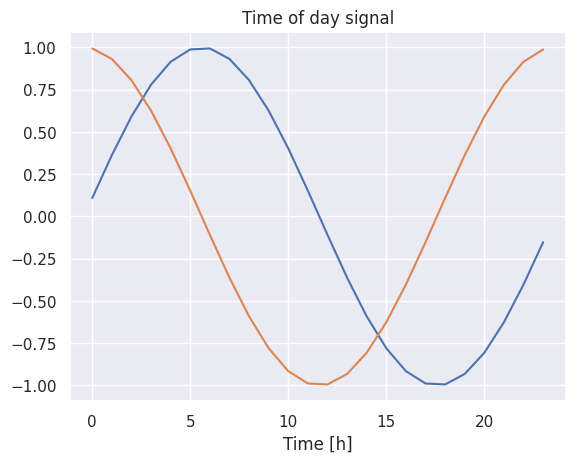

In [ ]:
# Get the timestamp/day/year in seconds
timestamp_s = final_weather_df['date'].map(pd.Timestamp.timestamp)
day = 24*60*60
year = (366)*day # using 366 since we have 2020 data which was a leap year

final_weather_df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
final_weather_df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
final_weather_df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
final_weather_df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Plot one day's worth of data
plt.plot(np.array(final_weather_df['day_sin'])[18:42])
plt.plot(np.array(final_weather_df['day_cos'])[18:42])
plt.xlabel('Time [h]')
plt.title('Time of day signal');

# Preparing Final Data Set
- Removing unnecessary columns
- Checking for outliers
- Creating train/test split
- Standardizing numeric features

In [ ]:
# Check for outliers in target variable
final_weather_df[['wind_speed']].describe()

,wind_speed
count,8777.000000
mean,2.186689
std,1.525325
min,0.198333
25%,1.038333
50%,1.781667
75%,2.875000
max,12.573333


In [ ]:
# Set the date as the index for the dataset.
final_weather_df.set_index('date', inplace=True)
final_weather_df.head()

,month,day,hour,atmospheric_pressure,air_temperature,potential_temperature,dew_point_temperature,relative_humidity,maximum_vapor_pressure,actual_vapor_pressure,...,duration_of_rain,solar_radiation,photosynthetically_active_radiation,max_photosynthetically_active_radiation,temperature,lagged_ma_wind_speed,day_sin,day_cos,year_sin,year_cos
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:25:00,1,1,6,1007.365000,-0.571667,272.018056,-2.101111,89.383333,5.872222,5.236944,...,0.0,0.000000,0.000000,0.000000,11.413611,0.813056,0.994056,-0.108867,-0.603404,0.797436
2020-01-01 07:25:00,1,1,7,1008.103889,-1.152222,271.380556,-2.445833,90.911111,5.627778,5.105000,...,0.0,0.000000,0.000000,0.000000,11.000278,0.826111,0.932008,-0.362438,-0.602833,0.797867
2020-01-01 08:25:00,1,1,8,1008.073611,-1.600833,270.935833,-2.724722,92.025000,5.442778,4.999444,...,0.0,0.000000,0.000000,0.000000,10.497500,0.842222,0.806445,-0.591310,-0.602262,0.798298
2020-01-01 09:25:00,1,1,9,1008.032500,-2.064444,270.476111,-3.045278,92.972222,5.255833,4.880278,...,0.0,1.620833,3.480278,4.380833,9.975556,0.889722,0.625923,-0.779884,-0.601691,0.798729
2020-01-01 10:25:00,1,1,10,1008.044722,-2.450278,270.090278,-3.345000,93.536111,5.101944,4.770278,...,0.0,20.450833,29.890556,33.408056,9.539444,0.877222,0.402747,-0.915311,-0.601120,0.799159


In [ ]:
# Take the last week of each month as the test set.
def last_week_per_month(df):
  '''

  Takes the last week of each month and stores
  the data in a test dataset.

  '''
  df = df.sort_values(['date', 'month'], ascending=[False, False])

  # Take the last 168 records for each month
  df = df.groupby('month').head(168)
  return df.sort_index()  # Drop the month column and sort by original index

# Create train and test datasets.
test_df = last_week_per_month(final_weather_df)
train_df = final_weather_df.drop(test_df.index)

In [ ]:
# Remove the date/day/hour columns in the final dataframes.
train_df.drop(columns=['day', 'hour', 'month'], inplace=True)
test_df.drop(columns=['day', 'hour', 'month'], inplace=True)

# Split into X and Y
train_x_df = train_df.drop(columns=['wind_speed'])
train_y_df = train_df[['wind_speed']]

test_x_df = test_df.drop(columns=['wind_speed'])
test_y_df = test_df[['wind_speed']]

In [ ]:
# # Create training, validation, and test datasets using a 60/20/20 split - stratified by month
# # creating the initial train test dataframes
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=X['month'], random_state=123)
# # creating the train and valid dataframes
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=X_train['month'], random_state=123)

# # Remove month variable
# X_train = X_train.drop(columns=['month'])
# X_val = X_val.drop(columns=['month'])
# X_test = X_test.drop(columns=['month'])

# # Print shapes of each set
# print('Shape of X_train:', X_train.shape)
# print('Shape of X_val:', X_val.shape)
# print('Shape of X_test:', X_test.shape)
# print('Shape of Y_train:', Y_train.shape)
# print('Shape of Y_val:', Y_val.shape)
# print('Shape of Y_test:', Y_test.shape)


### Scale/Normalize the data

In [ ]:
# Standardize numeric features based on training mean and std
X_train_std = train_x_df.copy()
#X_val_std = X_val.copy()
X_test_std = test_x_df.copy()

for feature in [col for col in train_x_df.columns if col not in ['day_sin', 'day_cos', 'year_sin', 'year_cos']]:
    X_train_std[feature] = X_train_std[feature].apply(lambda val: (val - train_x_df[feature].mean()) / train_x_df[feature].std(ddof=0))
    #X_val_std[feature] = X_val_std[feature].apply(lambda val: (val - train_x_df[feature].mean()) / train_x_df[feature].std(ddof=0))
    X_test_std[feature] = X_test_std[feature].apply(lambda val: (val - train_x_df[feature].mean()) / train_x_df[feature].std(ddof=0))

In [ ]:
# Check for NaN or infinite values
print(f"NaN in X_train_std: {np.isnan(X_train_std).sum()}")
print(f"NaN in Y_train: {np.isnan(train_y_df).sum()}")
print(f"Infinite in X_train_std: {np.isinf(X_train_std).sum()}")
print(f"Infinite in Y_train: {np.isinf(train_y_df).sum()}")

NaN in X_train_std: atmospheric_pressure                       0
air_temperature                            0
potential_temperature                      0
dew_point_temperature                      0
relative_humidity                          0
maximum_vapor_pressure                     0
actual_vapor_pressure                      0
vapor_pressure_deficit                     0
specific_humidity                          0
water_vapor_concentration                  0
air_density                                0
max_wind_speed                             0
wind_direction                             0
total_rainfall                             0
duration_of_rain                           0
solar_radiation                            0
photosynthetically_active_radiation        0
max_photosynthetically_active_radiation    0
temperature                                0
lagged_ma_wind_speed                       0
day_sin                                    0
day_cos                            

In [ ]:
# Save the dataframes

# X
X_train_std.to_csv('/content/drive/MyDrive/datasci_207_final_project/data/x_train.csv', index=False)
X_test_std.to_csv('/content/drive/MyDrive/datasci_207_final_project/data/x_test.csv', index=False)

# Y
train_y_df.to_csv('/content/drive/MyDrive/datasci_207_final_project/data/y_train.csv', index=False)
test_y_df.to_csv('/content/drive/MyDrive/datasci_207_final_project/data/y_test.csv', index=False)

### Create Time Series Split

In [ ]:
# TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, max_train_size=1000, test_size=144)

# Exploratory Data Analysis

<Axes: >

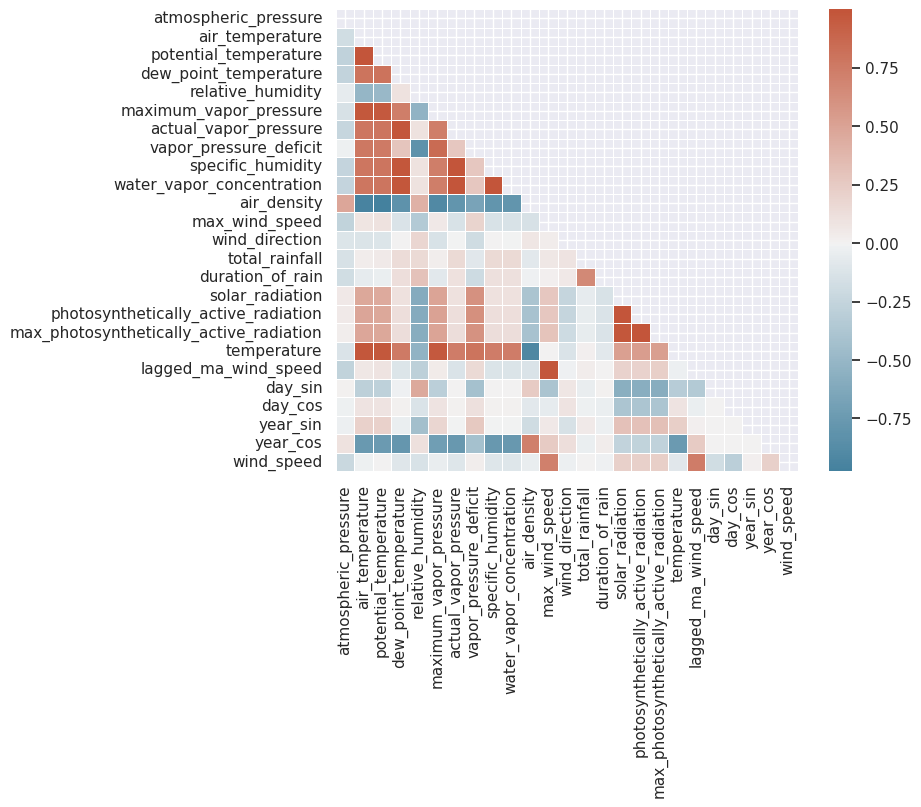

In [ ]:
# Correlation Matrix

# Add target variable and features to one df
training_df = pd.concat([X_train_std, train_y_df], axis=1)

# Compute the correlation matrix
corr = training_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

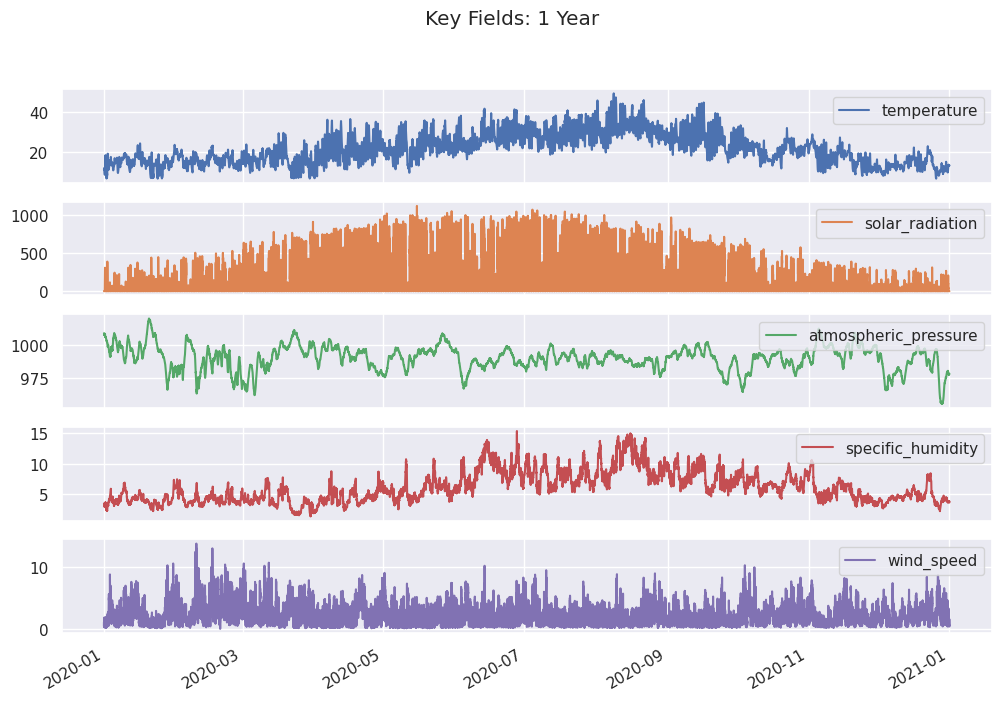

In [ ]:
# Look at the some of the key fields for a week.
key_fields = ['temperature', 'solar_radiation', 'atmospheric_pressure', 'specific_humidity', 'wind_speed']
plot_fields = weather_df[key_fields]
plot_fields.index = weather_df['date']
axes = plot_fields.plot(subplots=True,
                        figsize=(12,8),
                        xlabel='',
                        legend=True,
                        title='Key Fields: 1 Year')
for ax in axes:
  ax.legend(loc = 'upper right')
plt.show()

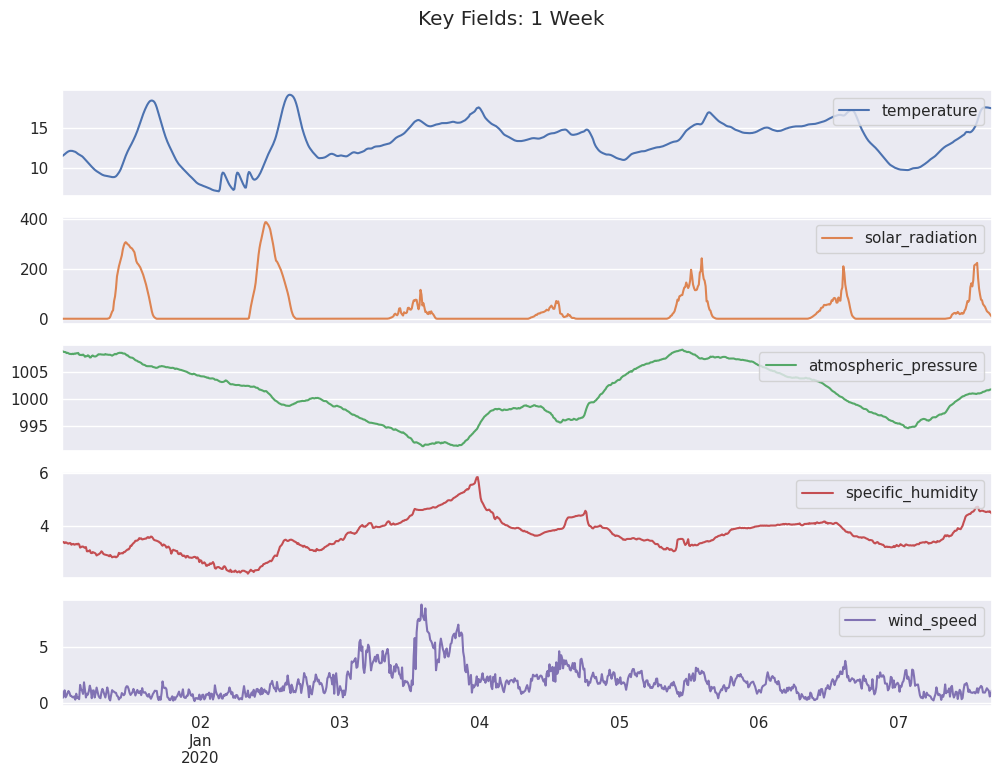

In [ ]:
# Look at the some of the key fields for a week.
key_fields = ['temperature', 'solar_radiation', 'atmospheric_pressure', 'specific_humidity', 'wind_speed']
plot_fields = weather_df[key_fields][:960]
plot_fields.index = weather_df['date'][:960]
axes = plot_fields.plot(subplots=True,
                        figsize=(12,8),
                        xlabel='',
                        legend=True,
                        title='Key Fields: 1 Week')
for ax in axes:
  ax.legend(loc = 'upper right')
plt.show()

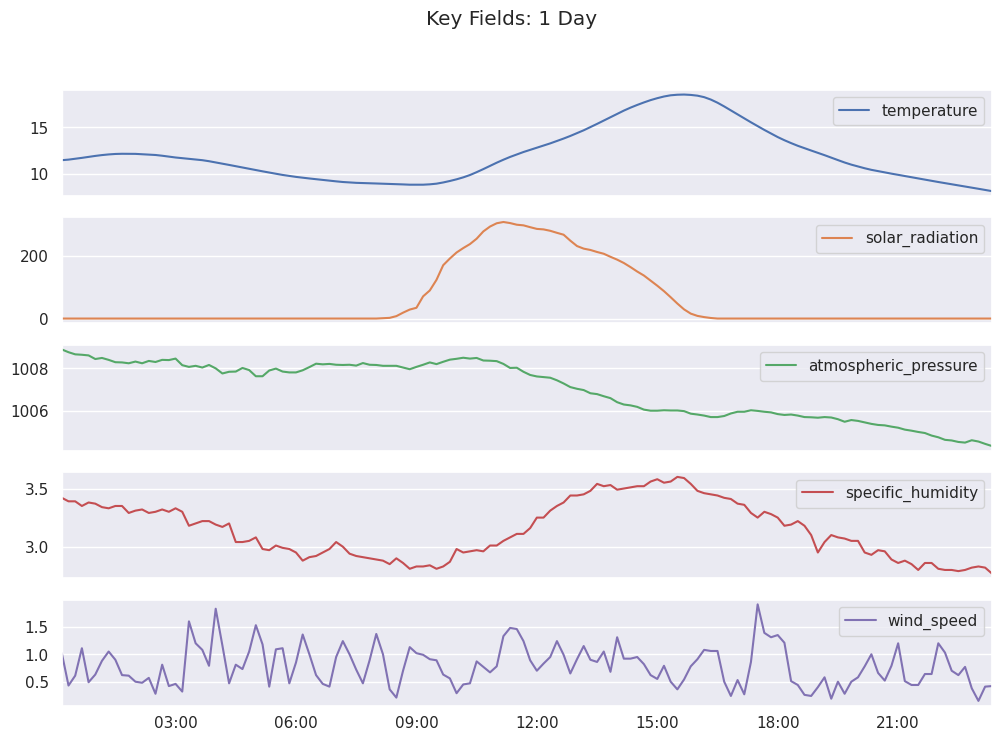

In [ ]:
# Look at the some of the key fields for a day.
key_fields = ['temperature', 'solar_radiation', 'atmospheric_pressure', 'specific_humidity', 'wind_speed']
plot_fields = weather_df[key_fields][:140]
plot_fields.index = weather_df['date'][:140]
axes = plot_fields.plot(subplots=True,
                        figsize=(12,8),
                        xlabel='',
                        legend=True,
                        title='Key Fields: 1 Day')
for ax in axes:
  ax.legend(loc = 'upper right')
plt.show()


#Baseline Model
For our baseline, the prediction will just be average training data wind speed

In [ ]:
baseline_train_pred = [np.mean(train_y_df['wind_speed'])] * len(train_y_df)
baseline_test_pred = [np.mean(test_y_df['wind_speed'])] * len(test_y_df)

train_mse = mean_squared_error(train_y_df['wind_speed'], baseline_train_pred)
test_mse = mean_squared_error(test_y_df['wind_speed'], baseline_test_pred)

print('Baseline Train MSE:', train_mse)
print('Baselline Validation MSE:', test_mse)

Baseline Train MSE: 2.320456740599759
Baselline Validation MSE: 2.3069426226322576


#Linear Regression Model


In [ ]:
# Ridge Regression Model with alpha regularization strength
ridge_model = Ridge(alpha=1.0)

# Getting the data ready for TimeSeriesSplit Cross-validation
# Further dividing training data into training and validation
train_mse_list = []
val_mse_list = []

# Cross-validation loop to protect temporal order of timeseries data
for fold, (train_index, val_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
    X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[val_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[val_index]

    # Fit the model
    ridge_model.fit(X_train, Y_train)

    # Make predictions
    train_pred = ridge_model.predict(X_train)
    val_pred = ridge_model.predict(X_val)

    # Evaluate performance using MSE
    train_mse = mean_squared_error(Y_train, train_pred)
    val_mse = mean_squared_error(Y_val, val_pred)

    # Store results
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)


Average Train MSE: 0.6162
Average Validation MSE: 0.6343


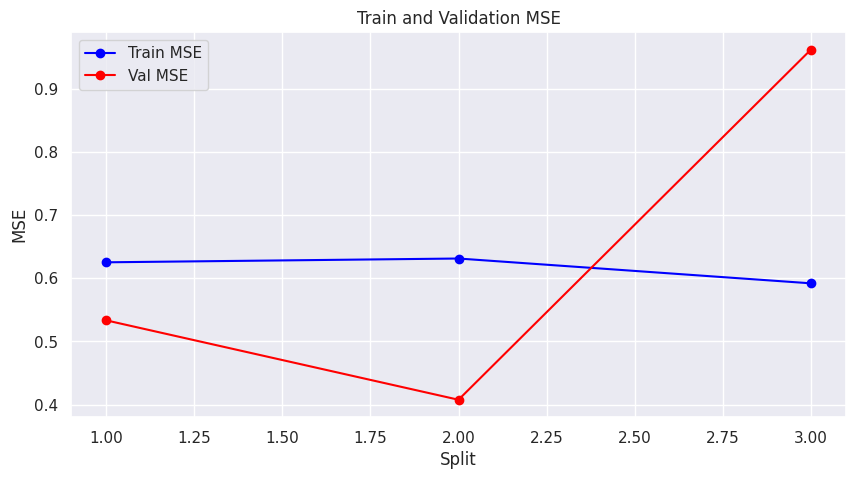

In [ ]:
# Calculate the average MSE for train and test sets
average_train_mse = np.mean(train_mse_list)
average_test_mse = np.mean(val_mse_list)

# Output the average MSE
print(f'\nAverage Train MSE: {average_train_mse:.4f}')
print(f'Average Validation MSE: {average_test_mse:.4f}')

# Visualize model performance
plt.figure(figsize=(10, 5))

# Plot for both train and test MSE for each split on the same graph
plt.plot(range(1, len(train_mse_list) + 1), train_mse_list, marker='o', color='blue', label='Train MSE')
plt.plot(range(1, len(val_mse_list) + 1), val_mse_list, marker='o', color='red', label='Val MSE')

# Plot formatting
plt.title('Train and Validation MSE')
plt.xlabel('Split')
plt.ylabel('MSE')
plt.legend()

# Tuning the Linear Regression Model

https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
# Define Ridge regression model
ridge = Ridge()

# Define hyperparameter grid

#tests 50 evenly distributed on a logarithmic scale between 10^(-5) and 10^5
alpha_values = np.logspace(-5, 5, num=50)
param_grid_values = {
    'alpha': alpha_values
}

# Set up GridSearchCV with TimeSeriesSplit; goal is minimizing MSE on validation data
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid_values, scoring='neg_mean_squared_error', cv=tss)

# Execute the grid search
grid_search.fit(X_train_std, train_y_df)

# Output the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'alpha': 21.209508879201927}
Best Cross-Validation Score: -0.5822971386556909


In [ ]:
# Ridge Regression Model with hyper-tuned alpha
ridge_model = grid_search.best_estimator_

# Getting the data ready for TimeSeriesSplit Cross-validation
# Further dividing training data into training and validation
train_mse_list = []
val_mse_list = []

# Cross-validation loop to protect temporal order of timeseries data
for fold, (train_index, val_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
    X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[val_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[val_index]

    # Fit the model
    ridge_model.fit(X_train, Y_train)

    # Make predictions
    train_pred = ridge_model.predict(X_train)
    val_pred = ridge_model.predict(X_val)

    # Evaluate performance using MSE
    train_mse = mean_squared_error(Y_train, train_pred)
    val_mse = mean_squared_error(Y_val, val_pred)

    # Store results
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)


Average Train MSE: 0.6324
Average Validation MSE: 0.5823


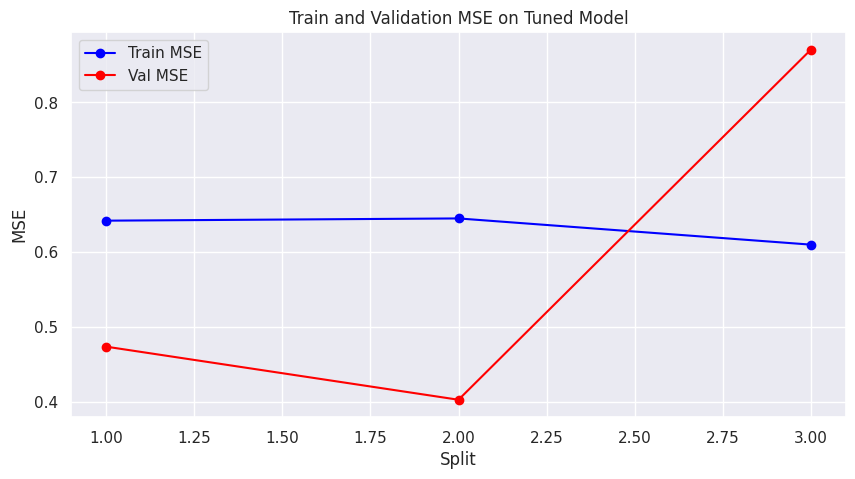

In [ ]:
# Calculate the average MSE for train and validation sets on new hyper-tuned model
average_train_mse = np.mean(train_mse_list)
average_test_mse = np.mean(val_mse_list)

# Output the average MSE
print(f'\nAverage Train MSE: {average_train_mse:.4f}')
print(f'Average Validation MSE: {average_test_mse:.4f}')

# Visualize model performance
plt.figure(figsize=(10, 5))

# Plot for both train and test MSE for each split on the same graph
plt.plot(range(1, len(train_mse_list) + 1), train_mse_list, marker='o', color='blue', label='Train MSE')
plt.plot(range(1, len(val_mse_list) + 1), val_mse_list, marker='o', color='red', label='Val MSE')

# Plot formatting
plt.title('Train and Validation MSE on Tuned Model')
plt.xlabel('Split')
plt.ylabel('MSE')
plt.legend()

# Neural Network Model

In [ ]:
# Set a seed.
tf.random.set_seed(1234)
tf.keras.backend.clear_session()

# Create an input layer.
nn_inputs = tf.keras.Input(shape=(24,))

# Create an output layer.
nn_outputs = tf.keras.layers.Dense(units=1)(nn_inputs)

# Create the model.
simple_nn_model = tf.keras.Model(inputs=nn_inputs, outputs=nn_outputs)

# View the summary parameters.
simple_nn_model.summary()

# Compile the NN model.
simple_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cross-validation loop to protect temporal order of timeseries data
for fold, (train_index, test_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
    X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[test_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[test_index]

    # Fit the model
    simple_nn_history = simple_nn_model.fit(X_train, Y_train,
                              validation_data=(X_val, Y_val),
                              epochs=30)

    # Evaluate on validation set
    val_loss = simple_nn_model.evaluate(X_val, Y_val, verbose=0)
    print(f"Validation Loss for Fold {fold + 1}: {val_loss}")
    print("-" * 30)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0647 - mean_squared_error: 9.0647 - val_loss: 6.6481 - val_mean_squared_error: 6.6481
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7846 - mean_squared_error: 7.7846 - val_loss: 5.2341 - val_mean_squared_error: 5.2341
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7477 - mean_squared_error: 6.7477 - val_loss: 4.1556 - val_mean_squared_error: 4.1556
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9050 - mean_squared_error: 5.9050 - val_loss: 3.3414 - val_mean_squared_error: 3.3414
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2140 - mean_squared_error: 5.2140 - val_loss: 2.7290 - val_mean_squared_error: 2.7290
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6400 - mean_squared_error: 4.6400 - val_loss: 2.2674 - val_mean_squared_error: 2.2674
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1567 - mean_squared_error: 4.1567 - val_loss: 1.9167 - val_mean

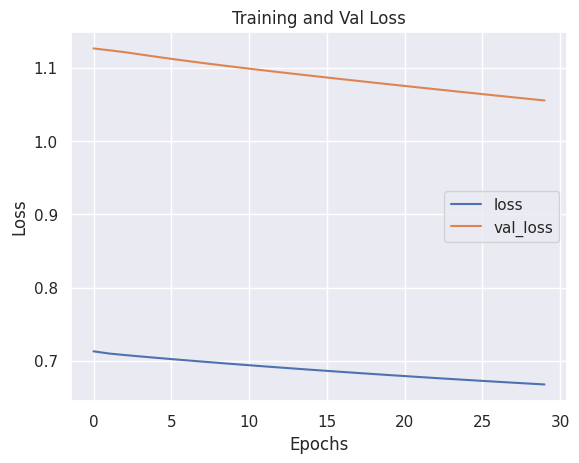

In [ ]:
simple_nn_history_df = pd.DataFrame(simple_nn_history.history)
simple_nn_history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Val Loss')
plt.show()

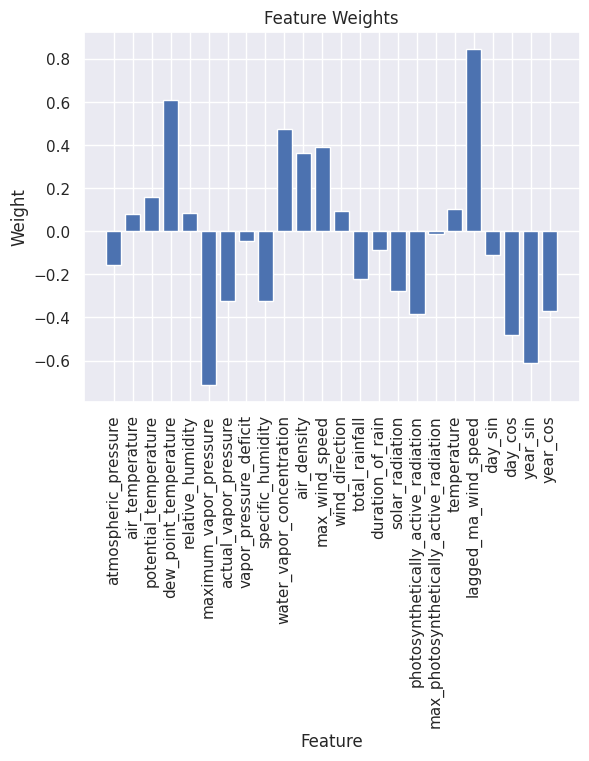

In [ ]:
# Look at the weights of the model
plot_weights = simple_nn_model.get_weights()[0]
plt.bar(x=list(train_x_df.columns), height=plot_weights.reshape(-1,))
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Feature Weights')
plt.show()

In [ ]:
# Set a seed.
tf.random.set_seed(1234)
tf.keras.backend.clear_session()

# Create an input layer.
nn_inputs = tf.keras.Input(shape=(24,))

# Create hidden layers.
nn_h1 = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(nn_inputs)
nn_h1 = tf.keras.layers.Dropout(0.2)(nn_h1)
nn_h2 = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(nn_h1)
nn_h2 = tf.keras.layers.Dropout(0.2)(nn_h2)
nn_h3 = tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(nn_h2)
nn_h3 = tf.keras.layers.Dropout(0.2)(nn_h3)


# Create an output layer.
nn_outputs = tf.keras.layers.Dense(units=1)(nn_h3)

# Create the model.
nn_model = tf.keras.Model(inputs=nn_inputs, outputs=nn_outputs)

# View the summary parameters.
nn_model.summary()

# Compile the NN model.
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 47,617 (186.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
untuned_all_histories = []
untuned_final_val_losses = []

# Cross-validation loop to protect temporal order of timeseries data
for fold, (train_index, test_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
    X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[test_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[test_index]

    # Fit the model
    nn_history = nn_model.fit(X_train, Y_train,
                              validation_data=(X_val, Y_val),
                              epochs=100)

    untuned_all_histories.append(nn_history.history)

    # Evaluate on validation set
    val_loss = nn_model.evaluate(X_val, Y_val, verbose=0)
    untuned_final_val_losses.append(val_loss)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.2870 - mean_squared_error: 5.2893 - val_loss: 5.5920 - val_mean_squared_error: 2.6142
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4315 - mean_squared_error: 3.4599 - val_loss: 4.4920 - val_mean_squared_error: 1.5388
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1807 - mean_squared_error: 2.2341 - val_loss: 4.0467 - val_mean_squared_error: 1.1213
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5362 - mean_squared_error: 1.6188 - val_loss: 3.8108 - val_mean_squared_error: 0.9177
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2340 - mean_squared_error: 1.3497 - val_loss: 3.5982 - val_mean_squared_error: 0.7405
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9733 - mean_squared_error: 1.1248 - val_loss: 3.4583 - val_mean_squared_error: 0.6373
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8013 - mean_squared_error: 0.9898 - val_loss: 3.3606 - v

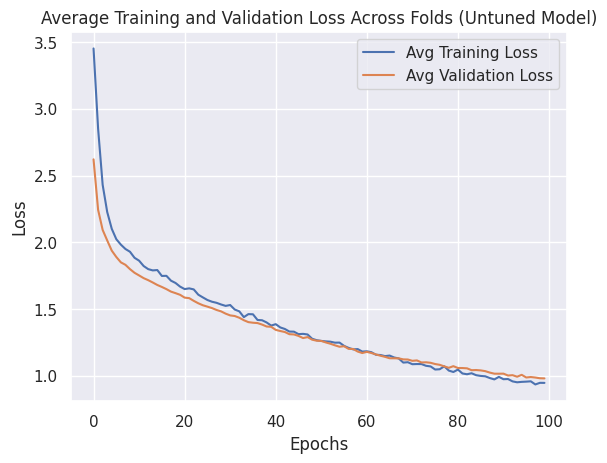

Mean Validation Loss: 0.7496 ± 0.2820


In [ ]:
# Calculate average training and validation losses across folds
untuned_avg_train_loss = np.mean([hist['loss'] for hist in untuned_all_histories], axis=0)
untuned_avg_val_loss = np.mean([hist['val_loss'] for hist in untuned_all_histories], axis=0)

# Plot aggregated losses
plt.plot(untuned_avg_train_loss, label="Avg Training Loss")
plt.plot(untuned_avg_val_loss, label="Avg Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across Folds (Untuned Model)")
plt.legend()
plt.show()

# Final validation loss summary
mean_val_loss = np.mean(untuned_final_val_losses)
std_val_loss = np.std(untuned_final_val_losses)
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


# Tuned Neural Network

In [ ]:
# L2 regularization aka ridge regression reduces overfitting by skrinking the magnitudes of coefficients
#dropouts randonly drop neurons to reduce model reliance on specific neurons and help w generalization
def build_nn_hp(hp):
    tf.keras.backend.clear_session()

    # Input layer
    nn_inputs = tf.keras.Input(shape=(24,))

    # Hidden layers

    #tune number of units alpha value in L2 regularizer
    nn_h1 = tf.keras.layers.Dense(units=hp.Int("units_h1", min_value=64, max_value=256, step=32), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_h1", min_value=1e-4, max_value=1e-2, sampling="log")))(nn_inputs)

    #tune nn_h1 droupout rate
    nn_h1 = tf.keras.layers.Dropout(hp.Float("dropout_h1", min_value=0.05, max_value=0.3, step=0.05))(nn_h1)

    #tune number of units alpha value in L2 regularizer
    nn_h2 = tf.keras.layers.Dense(units=hp.Int("units_h2", min_value=64, max_value=256, step=32),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_h2", min_value=1e-4, max_value=1e-2, sampling="log")))(nn_h1)

    #tune nn_h2 droupout rate
    nn_h2 = tf.keras.layers.Dropout(hp.Float("dropout_h2", min_value=0.2, max_value=0.5, step=0.05))(nn_h2)

    #tune number of units alpha value in L2 regularizer
    nn_h3 = tf.keras.layers.Dense(units=hp.Int("units_h3", min_value=64, max_value=256, step=32), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_h3", min_value=1e-4, max_value=1e-2, sampling="log")))(nn_h2)

    #tune nn_h3 droupout rate
    nn_h3 = tf.keras.layers.Dropout(hp.Float("dropout_h3", min_value=0.2, max_value=0.5, step=0.05))(nn_h3)

    # Output layer
    nn_outputs = tf.keras.layers.Dense(units=1)(nn_h3)

    # Create the model
    nn_model = tf.keras.Model(inputs=nn_inputs, outputs=nn_outputs)

    #tune learning rate
    learning_rate = hp.Float("learning_rate",min_value=1e-5, max_value=1e-1, sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    nn_model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    return nn_model


In [ ]:
#if early stopping occurs, differnet folds may have different history lengths
#pad each fold with last value to match longest history legnth
def pad_histories(histories):
    max_epochs = max(len(hist['loss']) for hist in histories)  #calculate length of longest history
    padded_histories = []
    for history in histories:
        padded = {
            key: np.pad(values, (0, max_epochs - len(values)), mode='edge')  #pad histories with last value wwhere necessary
            for key, values in history.items()
        }
        padded_histories.append(padded)
    return padded_histories


In [ ]:
#our objective will be to minimize average validation loss across folds
def objective_nn_hp(hp):
    val_losses = []

    # Cross-validation loop to protect temporal order of time-series data
    for fold, (train_index, test_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
        X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[test_index]
        Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[test_index]

        # Build and train the model
        nn_model = build_nn_hp(hp)

        #build in early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10, #stop if val_loss hasn't improved after 10 consecutive epochs
            restore_best_weights=True
        )

        nn_model.fit(
            X_train, Y_train,
            validation_data=(X_val, Y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )

        #evaluate on the validation
        val_loss = nn_model.evaluate(X_val, Y_val, verbose=0)[0]
        val_losses.append(val_loss)

    # Return the mean validation loss across folds
    return np.mean(val_losses)


In [ ]:
#define custom tuner class to handle time-series cross-validation, with goal of minimizing average val_loss across folds
class TimeSeriesTuner(RandomSearch):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        # Use the custom objective function
        score = objective_nn_hp(trial.hyperparameters)
        #pipe the score to the tuner
        self.oracle.update_trial(trial.trial_id, {'score': score})


In [ ]:
# Initialize the tuner
nn_tuner = TimeSeriesTuner(
    hypermodel=build_nn_hp,
    #optimize for smallest value of objective_hp function created above
    objective=Objective("score", direction="min"),
    max_trials=10,  # Number of hyperparameter trials
    directory="tuner_nn_hps",
    project_name="tuner_nn_hps"
)

#exeucte the search
nn_tuner.search()


Reloading Tuner from tuner_nn_hps/tuner_nn_hps/tuner0.json


In [ ]:
#tuned hyperparameters
best_hps = nn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

tuned_final_val_losses = []
tuned_all_histories = []  # Collect histories for all folds

#build and train the final model using tuned hyperparameters

for fold, (train_index, val_index) in enumerate(tss.split(X_train_std, train_y_df), 1):
    X_train, X_val = X_train_std.iloc[train_index], X_train_std.iloc[val_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[val_index]

    #rebuild the model for each fold to prevent leakage
    improved_nn = build_nn_hp(best_hps)

    # Build in early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10, #stop if no improvement for 10 consecutive epochs
        restore_best_weights=True
    )

    # Train and collect history on the current fold
    history = improved_nn.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Append the history for analysis
    tuned_all_histories.append(history.history)

    # Evaluate on validation set
    val_loss = improved_nn.evaluate(X_val, Y_val, verbose=0)
    tuned_final_val_losses.append(val_loss)

Best Hyperparameters: {'units_h1': 160, 'l2_h1': 0.00025430520924425877, 'dropout_h1': 0.25, 'units_h2': 96, 'l2_h2': 0.00018980757724363517, 'dropout_h2': 0.35000000000000003, 'units_h3': 64, 'l2_h3': 0.0007085245085911898, 'dropout_h3': 0.25, 'learning_rate': 0.008076262788470068}


In [ ]:
improved_nn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 160)                 │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │          15,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,189 (301.52 KB)

 Trainable params: 25,729 (100.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,460 (201.02 KB)

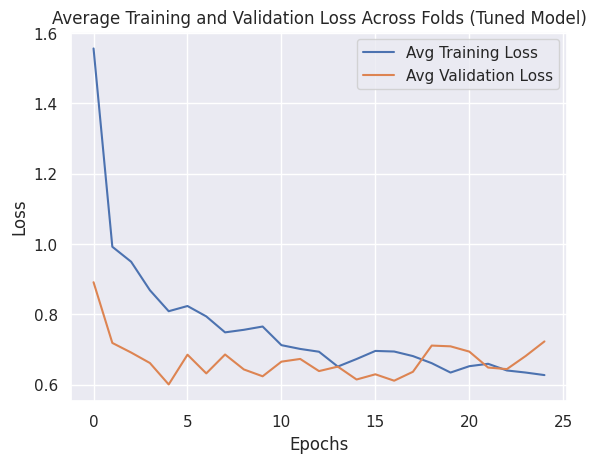

Mean Validation Loss: 0.5550 ± 0.1839


In [ ]:
# Pad histories to handle varying lengths
padded_histories = pad_histories(tuned_all_histories)

# Aggregate training and validation losses
avg_train_loss = np.mean([hist['loss'] for hist in padded_histories], axis=0)
avg_val_loss = np.mean([hist['val_loss'] for hist in padded_histories], axis=0)

# Plot aggregated losses
plt.plot(avg_train_loss, label="Avg Training Loss")
plt.plot(avg_val_loss, label="Avg Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across Folds (Tuned Model)")
plt.legend()
plt.show()

# Final validation loss summary
mean_val_loss = np.mean(tuned_final_val_losses)
std_val_loss = np.std(tuned_final_val_losses)
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


# CNN

In [ ]:
# reshaping data for CNN input
X_train_cnn = X_train_std.to_numpy().reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_cnn = X_test_std.to_numpy().reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [ ]:
def build_cnn():
  # building CNN
  cnn_model = models.Sequential()

  # adding 1D convolutional layer
  cnn_model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))

  # adding max pooling layer to reduce dimensionality
  cnn_model.add(layers.MaxPooling1D(pool_size=2))

  # adding another 1D Ccnvolutional layer
  cnn_model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))

  # adding another max pooling layer
  cnn_model.add(layers.MaxPooling1D(pool_size=2))

  # flattening
  cnn_model.add(layers.Flatten())

  # adding a dense layer
  cnn_model.add(layers.Dense(64, activation='relu'))

  # adding an output layer
  cnn_model.add(layers.Dense(1))

  # compiling
  cnn_model.compile(optimizer='adam', loss='mean_squared_error')

  cnn_model.summary()

  return cnn_model



In [ ]:
cnn_model = build_cnn()

# Cross-validation loop for final model evaluation
untuned_final_val_losses = []
untuned_all_histories = []

# Cross-validation loop to protect temporal order of timeseries data
for fold, (train_index, test_index) in enumerate(tss.split(X_train_cnn, train_y_df), 1):
    X_train, X_val = X_train_cnn[train_index], X_train_cnn[test_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[test_index]

    #rebuild model each time
    cnn_model= build_cnn()

    #build in early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10, #stop if val_loss hasn't improved after 10 consecutive epochs
            restore_best_weights=True
        )

    # Fit the model
    cnn_history = cnn_model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    untuned_all_histories.append(cnn_history.history)

    # Evaluate on validation set
    val_loss = cnn_model.evaluate(X_val, Y_val, verbose=0)
    untuned_final_val_losses.append(val_loss)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 0 (0.00 B)

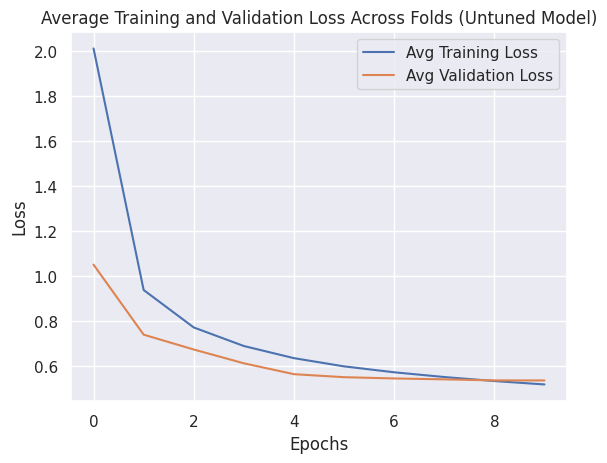

Mean Validation Loss: 0.5340 ± 0.2528


In [ ]:
# Calculate average training and validation losses across folds
untuned_avg_train_loss = np.mean([hist['loss'] for hist in untuned_all_histories], axis=0)
untuned_avg_val_loss = np.mean([hist['val_loss'] for hist in untuned_all_histories], axis=0)

# Plot aggregated losses
plt.plot(untuned_avg_train_loss, label="Avg Training Loss")
plt.plot(untuned_avg_val_loss, label="Avg Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across Folds (Untuned Model)")
plt.legend()
plt.show()

# Final validation loss summary
mean_val_loss = np.mean(untuned_final_val_losses)
std_val_loss = np.std(untuned_final_val_losses)
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")

# Tuned CNN

In [ ]:
def build_cnn_hp(hp):
  # building CNN
  cnn_model = models.Sequential()

  #tuning number of filters, kernal_size, and pool_size

  filters_layer_1=hp.Int("filters_layer_1", min_value=10, max_value=50, step=10)
  filters_layer_2=hp.Int("filters_layer2", min_value=10, max_value=50, step=10)

  kernel_size_layer_1=hp.Int("kernel_size_layer_1", min_value=1, max_value=5, step=1)
  kernel_size_layer_2=hp.Int("kernel_size_layer2", min_value=1, max_value=5, step=1)

  activation_layer_1 = hp.Choice("activation_layer_1", values=["relu", "tanh", "sigmoid"])
  activation_layer_2 = hp.Choice("activation_layer_2", values=["relu", "tanh", "sigmoid"])


  pool_size_layer_1=hp.Int("pool_size_layer_1", min_value=2, max_value=5, step=1)
  pool_size_layer_2=hp.Int("pool_size_layer_2", min_value=2, max_value=5, step=1)

  # adding 1D convolutional layer
  cnn_model.add(layers.Conv1D(filters=filters_layer_1, kernel_size=kernel_size_layer_1, activation=activation_layer_1, input_shape=(X_train_cnn.shape[1], 1)))

  # adding max pooling layer to reduce dimensionality
  cnn_model.add(layers.MaxPooling1D(pool_size=pool_size_layer_1))

  # adding another 1D Ccnvolutional layer
  cnn_model.add(layers.Conv1D(filters=filters_layer_2, kernel_size=kernel_size_layer_2, activation=activation_layer_2))

  # adding another max pooling layer
  cnn_model.add(layers.MaxPooling1D(pool_size=pool_size_layer_2))

  # flattening
  cnn_model.add(layers.Flatten())

  # adding a dense layer
  cnn_model.add(layers.Dense(64, activation='relu'))

  # adding an output layer
  cnn_model.add(layers.Dense(1))

  # compiling
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  cnn_model.compile(optimizer='adam', loss='mean_squared_error')

  return cnn_model

In [ ]:
def objective_cnn_hp(hp):
    val_losses = []

    # Cross-validation loop to protect temporal order of time-series data
    for fold, (train_index, test_index) in enumerate(tss.split(X_train_cnn, train_y_df), 1):
        X_train, X_val = X_train_cnn[train_index], X_train_cnn[test_index]
        Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[test_index]

        # Build and train the model
        nn_model = build_cnn_hp(hp)

        #build in early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        nn_model.fit(
            X_train, Y_train,
            validation_data=(X_val, Y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )

        #evaluate on the validation
        val_loss = nn_model.evaluate(X_val, Y_val, verbose=0)
        val_losses.append(val_loss)

        print(f"Fold {fold}: Validation Loss = {val_loss:.4f}")

    # Return the mean validation loss across folds
    return np.mean(val_losses)

In [ ]:
class TimeSeriesTuner(RandomSearch):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        # Use the custom objective function
        score = objective_cnn_hp(trial.hyperparameters)
        #pipe the score to the tuner
        self.oracle.update_trial(trial.trial_id, {'score': score})

In [ ]:
# Initialize the tuner
cnn_tuner = TimeSeriesTuner(
    hypermodel=build_cnn_hp,
    #optimize for smallest value of objective_hp function created above
    objective=Objective("score", direction="min"),
    max_trials=10,  # Number of hyperparameter trials
    directory="cnn_hp_tune",
    project_name="cnn_hp_tune"
)

#exeucte the search
cnn_tuner.search()


Trial 10 Complete [00h 00m 43s]
score: 0.8905456066131592

Best score So Far: 0.5272234578927358
Total elapsed time: 00h 04m 13s


In [ ]:
#tuned hyperparameters
best_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

tuned_final_val_losses = []
tuned_all_histories = []

# Cross-validation loop for tuned model evaluation
for fold, (train_index, val_index) in enumerate(tss.split(X_train_cnn, train_y_df), 1):
    X_train, X_val = X_train_cnn[train_index], X_train_cnn[val_index]
    Y_train, Y_val = train_y_df.iloc[train_index], train_y_df.iloc[val_index]

    improved_cnn = build_cnn_hp(best_hps)

    #build in early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

    history = improved_cnn.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    tuned_all_histories.append(history.history)

    #evaluate on validation set
    val_loss = improved_cnn.evaluate(X_val, Y_val, verbose=0)
    tuned_final_val_losses.append(val_loss)

Best Hyperparameters: {'filters_layer_1': 40, 'filters_layer2': 10, 'kernel_size_layer_1': 5, 'kernel_size_layer2': 4, 'activation_layer_1': 'relu', 'activation_layer_2': 'sigmoid', 'pool_size_layer_1': 4, 'pool_size_layer_2': 2}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

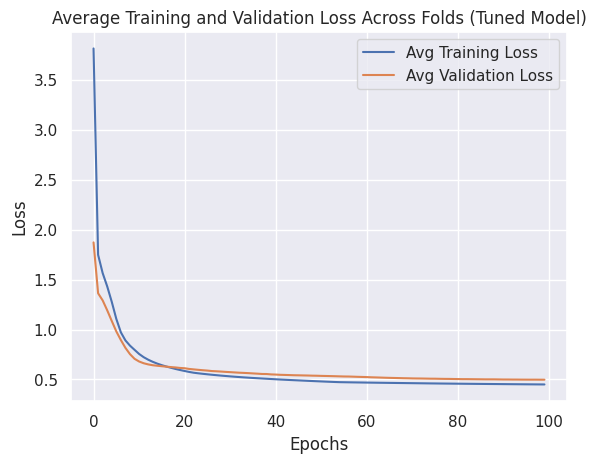

Mean Validation Loss: 0.4867 ± 0.1695


In [ ]:
# Pad histories to handle varying lengths
padded_histories = pad_histories(tuned_all_histories)

# Aggregate training and validation losses
avg_train_loss = np.mean([hist['loss'] for hist in padded_histories], axis=0)
avg_val_loss = np.mean([hist['val_loss'] for hist in padded_histories], axis=0)

# Plot aggregated losses
plt.plot(avg_train_loss, label="Avg Training Loss")
plt.plot(avg_val_loss, label="Avg Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across Folds (Tuned Model)")
plt.legend()
plt.show()

# Final validation loss summary
mean_val_loss = np.mean(tuned_final_val_losses)
mean_val_loss = np.mean(tuned_final_val_losses)

std_val_loss = np.std(tuned_final_val_losses)
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


In [ ]:
# reshaping data for CNN input
X_train_cnn = X_train_std.to_numpy().reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_cnn = X_test_std.to_numpy().reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [ ]:
# Evaluate on training data
train_loss = improved_cnn.evaluate(X_train_cnn, train_y_df.values.reshape(-1, 1), verbose=1)

# Evaluate on test data
test_loss = improved_cnn.evaluate(X_test_cnn, test_y_df, verbose=1)

print(f"Test Loss: {test_loss}")


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4222
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6148
Test Loss: 2.4114246368408203


In [ ]:
# Standardize numeric features based on training mean and std
X_train_std = train_x_df.copy()
#X_val_std = X_val.copy()
X_test_std = test_x_df.copy()

for feature in [col for col in train_x_df.columns if col not in ['day_sin', 'day_cos', 'year_sin', 'year_cos']]:
    X_train_std[feature] = X_train_std[feature].apply(lambda val: (val - train_x_df[feature].mean()) / train_x_df[feature].std(ddof=0))
    X_test_std[feature] = X_test_std[feature].apply(lambda val: (val - train_x_df[feature].mean()) / train_x_df[feature].std(ddof=0))

In [ ]:
# Evaluate on training data
train_loss = improved_nn.evaluate(X_train_std, train_y_df.values.reshape(-1, 1), verbose=1)

# Evaluate on test data
test_loss = improved_nn.evaluate(X_test_std, test_y_df, verbose=1)

print(f"Test Loss: {test_loss}")


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4061 - mean_squared_error: 1.3444
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5572 - mean_squared_error: 1.4956
Test Loss: [1.2756891250610352, 1.2140346765518188]
